In [1]:
# Data and stats
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Generate data

In [2]:
seed = 111
rng = np.random.default_rng(seed)

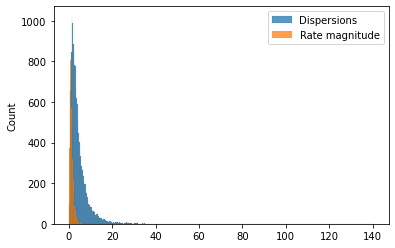

In [ ]:
n_genes = 15000  # number of genes to simulate
n_cells = 1000  # number of cells/samples to simulate


# Prior distributions to make each gene unique:
# The shape parameter (rr) controls overdispersion:
#     Smaller rr → More variance.
#     Larger rr → Closer to a Poisson.

# The scale parameter (ss) controls the magnitude of rates (λλ).
#     Larger ss → Higher expected counts.
#     Smaller ss → Lower expected counts.

r_values = rng.lognormal(mean=1.2, sigma=0.8, size=n_genes)  # Overdispersion
s_values = rng.lognormal(mean=0.1, sigma=0.6, size=n_genes)  # Scale for lambda

sns.histplot(r_values, label="Dispersions")
sns.histplot(s_values, label="Rate magnitude")
plt.legend()

In [ ]:
samples = np.zeros((n_genes, n_cells), dtype=np.int32)

for i in range(n_genes):
    lambdas = np.random.gamma(shape=r_values[i], scale=s_values[i], size=n_cells)
    samples[i, :] = np.random.poisson(lambdas)

samples_df = pd.DataFrame(np.transpose(samples))

display(samples_df)

,0,1,2,3,4,5,6,7,8,9,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,13,3,10,2,8,13,1,0,3,6,...,7,0,12,23,13,1,10,5,22,2
1,12,0,11,3,22,6,4,0,1,0,...,4,0,8,3,6,1,10,11,47,3
2,19,0,2,2,19,11,0,0,0,3,...,6,1,11,13,9,0,4,3,37,1
3,16,2,5,4,13,17,1,0,0,4,...,9,2,14,19,15,0,3,10,24,4
4,3,0,5,1,6,15,0,1,2,7,...,0,2,7,4,14,0,1,14,37,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,11,0,3,0,14,26,0,0,1,0,...,7,3,19,8,13,0,6,11,73,2
996,9,0,5,0,16,17,2,0,3,4,...,10,2,7,5,11,0,13,8,30,3
997,18,1,12,0,5,9,0,1,2,5,...,7,4,17,2,13,1,4,8,35,6
998,8,2,5,0,17,12,0,0,0,6,...,6,0,4,15,7,0,4,6,58,2


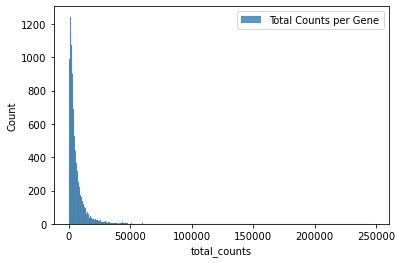

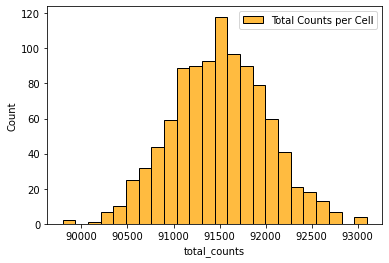

In [26]:
stats_genes = pd.DataFrame(data={"total_counts": samples_df.sum().to_list()})
stats_cells = pd.DataFrame(
    data={
        "total_counts": samples_df.sum(axis=1).to_list(),
        "n_genes_above_0_counts": samples_df.apply(
            lambda row: (row > 0).sum(), axis=1
        ).to_list(),
    }
)

sns.histplot(stats_genes["total_counts"], label="Total Counts per Gene")
plt.legend()
plt.show()

sns.histplot(stats_cells["total_counts"], label="Total Counts per Cell", color="orange")
plt.legend()
plt.show()

<AxesSubplot: xlabel='total_counts', ylabel='n_genes_above_0_counts'>

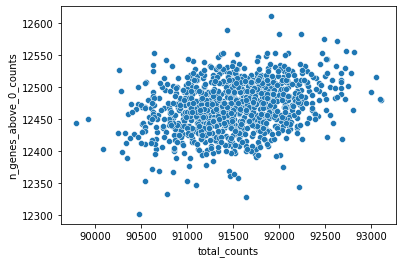

In [27]:
sns.scatterplot(data=stats_cells, x="total_counts", y="n_genes_above_0_counts")

# TODO:
- Downsample sample reads to create 0 inflated distribution
- Normalize genes and samples as in the scanpy tutorial
- Test the effect of log1p normalization with different pseudocounts

/tmp/ipykernel_1786461/3345934003.py:21: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(counts.T)


AnnData object with n_obs × n_vars = 1000 × 15000

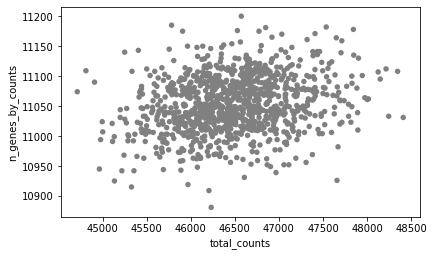

In [34]:
import numpy as np
import scipy.stats as stats
import scanpy as sc

n_genes = 15000
n_cells = 1000

# Simulate gene expression as Negative Binomial (overdispersed Poisson)
mean_expr = np.random.gamma(shape=2, scale=2, size=n_genes)  # Base expression levels
dispersion = 0.4  # Higher dispersion = more dropout
counts = np.array(
    [
        stats.nbinom.rvs(
            n=1 / dispersion, p=mean / (mean + 1 / dispersion), size=n_cells
        )
        for mean in mean_expr
    ]
)

# Convert to an AnnData object
adata = sc.AnnData(counts.T)
display(adata)

sc.pp.calculate_qc_metrics(adata, inplace=True, log1p=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

AnnData object with n_obs × n_vars = 1000 × 15000
    obs: 'blobs'

/mnt/weird_vol/miniforge3/envs/downstr/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/weird_vol/miniforge3/envs/downstr/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/weird_vol/miniforge3/envs/downstr/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


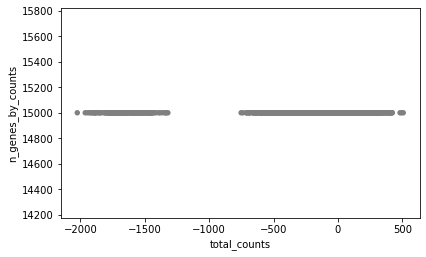

In [33]:
adata2 = sc.datasets.blobs(n_variables=15000, n_centers=5, n_observations=1000)
display(adata2)

sc.pp.calculate_qc_metrics(adata2, inplace=True, log1p=True)
sc.pl.scatter(adata2, "total_counts", "n_genes_by_counts")